# Comp336 Assignment 1 Part 2 Report
### Wuwei Zhang
### 201522671
#### In this part, I use jupyter notebook to write this report, and I use the following packages:

In [534]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator
from sklearn.decomposition import PCA

## Step1: Load CSV Data
#### Successfully load the stock data by using pd.read_csv() and the information of the data set is shown below:

In [535]:
df_stock = pd.read_csv('stock_data.csv')
# Assign the data type to df
df_stock["date"] = df_stock["date"].astype(dtype='datetime64')
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


## Step2: Remove Duplicate and Sort Name
#### Remove the duplicate data by using the method drop_duplicates() and sort the name by using the method sort_values().
#### The first five names and the last five names are shown below:

In [536]:
distinct_name = sorted(df_stock['Name'].drop_duplicates())
last_5_names = distinct_name[-5:]
first_5_names = distinct_name[:5]
print(f"There are {len(distinct_name)} unique names in this stock data set")
print(f"The first 5 names are: {first_5_names} and the last 5 names are: {last_5_names}")

There are 505 unique names in this stock data set
The first 5 names are: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV'] and the last 5 names are: ['XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']


## Step3: Filter out all names
#### First, I divide the data set into three parts: before 2014, between 2014 and 2017, and after 2017.
#### Then, by using .dropduplicates() to remove the duplicate names in each part, we will to keep the names that are in all three parts.
#### Therefore, names we want to remove are which appear in before 2014 or after 2017 but not in between 2014 and 2017.
#### The number of names we want to remove, and the first and the last five names we want to keep are shown below:

In [537]:
df_before_2014 = df_stock[pd.to_datetime('1st Jan 2014') >= df_stock["date"]]
df_after_2017 = df_stock[pd.to_datetime('31st Dec 2017') <= df_stock["date"]]
df_between = df_stock[(df_stock.date > pd.to_datetime('1st Jan 2014'))
                      & (df_stock.date < pd.to_datetime('31st Dec 2017'))]

# All names that appears in the four year period
names_between = df_between.Name.drop_duplicates()
# All names that has 
names_before = df_before_2014.Name.drop_duplicates()
names_after = df_after_2017.Name.drop_duplicates()
# Remove names_between but not in names_before and names_after
names_remove = names_between[(names_between.isin(names_before) == False)
                             | (names_between.isin(names_after) == False)]
names_filter = names_between[names_between.isin(names_remove) == False]
print(f"There are {len(names_remove)} names will be removed and they are: {names_remove.values}")
print(f"There are {len(names_filter)} names will be kept")

There are 22 names will be removed and they are: ['APTV' 'BHF' 'BHGE' 'CFG' 'CSRA' 'DWDP' 'DXC' 'EVHC' 'FTV' 'GOOG' 'HLT'
 'HPE' 'HPQ' 'INFO' 'KHC' 'NAVI' 'PYPL' 'QRVO' 'SYF' 'UA' 'WLTW' 'WRK']
There are 483 names will be kept


#### The number of rows of df_stock after removing the names is shown below:

In [538]:
df_stock_filtered = df_stock[~df_stock.Name.isin(names_remove)]
len(df_stock_filtered), len(df_stock)
print('The number of rows after filtering is: ', len(df_stock_filtered))

The number of rows after filtering is:  607342


## Step4: Identify the set of dates that are common to all the remaining names
#### Using the method .drop_duplicates() to remove the duplicate dates in the df_stock_filtered. Then, I removed the dates that are not in the range of 2014-2017.
#### The first five dates and the last five dates are shown below:


In [539]:
# Calculate the date before filtering
date_before_filter = df_stock_filtered.date.drop_duplicates()
# Remove all the dates that are before 1st Jan 2014 or after 31st Dec 2017
df_stock_filtered = df_stock_filtered[(df_stock_filtered.date >= pd.to_datetime('1st Jan 2014'))
                                      & (df_stock_filtered.date <= pd.to_datetime('31st Dec 2017'))]
date_filter = df_stock_filtered.date.drop_duplicates()

print(f"There are {len(date_before_filter)} dates before applying filter and "
      f"{len(date_filter)} dates in the filtered data set")
print(f"The first 5 dates before applying filter are: {date_filter.values[:5]}, "
      f"\n the last 5 dates before applying filter are: {date_filter.values[-5:]}")

There are 1259 dates before applying filter and 1007 dates in the filtered data set
The first 5 dates before applying filter are: ['2014-01-02T00:00:00.000000000' '2014-01-03T00:00:00.000000000'
 '2014-01-06T00:00:00.000000000' '2014-01-07T00:00:00.000000000'
 '2014-01-08T00:00:00.000000000'], 
 the last 5 dates before applying filter are: ['2017-12-22T00:00:00.000000000' '2017-12-26T00:00:00.000000000'
 '2017-12-27T00:00:00.000000000' '2017-12-28T00:00:00.000000000'
 '2017-12-29T00:00:00.000000000']


## Step5: Build a new pandas dataframe with the filtered data and the value is close price
#### Using .pivot() to build a new dataframe with the filtered data and the value is close price.

In [540]:
# df contain the “close” values for each corresponding name and date.
df_all_close = df_stock_filtered.pivot(index='date', columns='Name', values='close')
df_all_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 to 2017-12-29
Columns: 483 entries, A to ZTS
dtypes: float64(483)
memory usage: 3.7 MB


#### The first five rows of the dataframe are shown below:

In [541]:
# Show the first 5 rows of the dataframe for close price
df_all_close.head(5)

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,56.21,25.360,109.74,79.0185,51.98,69.89,38.23,81.13,59.29,49.28,...,31.25,45.97,99.75,47.96,47.64,34.16,75.09,92.24,29.65,32.36
2014-01-03,56.92,26.540,112.88,77.2828,52.30,69.94,38.64,81.40,59.16,49.61,...,30.81,45.62,99.51,48.19,47.96,34.47,75.56,92.64,29.86,32.05
2014-01-06,56.64,27.030,111.80,77.7042,50.39,69.69,39.15,80.54,58.12,49.33,...,30.37,45.42,99.66,47.90,48.36,34.41,75.50,93.24,29.65,31.98
2014-01-07,57.45,26.905,113.18,77.1481,50.49,70.45,38.85,81.52,58.97,49.59,...,30.37,45.52,101.07,48.64,48.76,34.51,76.56,95.10,29.74,32.10
2014-01-08,58.39,27.630,112.30,77.6371,50.36,71.14,39.20,82.15,58.90,49.71,...,30.39,45.91,100.74,48.73,48.32,34.49,76.53,97.43,30.00,31.74


## Step6: Create a dataframe containing returns
#### First, the returns are calculated by subtracting the previous close price from current and dividing by the previous close price.
#### Second, Removing the first row and fill the cells with NaN to 0 because the value is not changed in these dates.
#### The first five rows of the dataframe are shown below:

In [542]:
# calculate return for single name
def get_returns(stock):
    return (stock - stock.shift(1)) / stock.shift(1)

# calculate the return for all names
df_returns = df_all_close.apply(get_returns)[1:]

# transfer the NaN to 0 because the close price is not available and not change in these date
df_returns.fillna(0, inplace=True)

df_returns.head(5)

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.012631,0.046530,0.028613,-0.021966,0.006156,0.000715,0.010725,0.003328,-0.002193,0.006696,...,-0.014080,-0.007614,-0.002406,0.004796,0.006717,0.009075,0.006259,0.004337,0.007083,-0.009580
2014-01-06,-0.004919,0.018463,-0.009568,0.005453,-0.036520,-0.003574,0.013199,-0.010565,-0.017579,-0.005644,...,-0.014281,-0.004384,0.001507,-0.006018,0.008340,-0.001741,-0.000794,0.006477,-0.007033,-0.002184
2014-01-07,0.014301,-0.004624,0.012343,-0.007157,0.001985,0.010905,-0.007663,0.012168,0.014625,0.005271,...,0.000000,0.002202,0.014148,0.015449,0.008271,0.002906,0.014040,0.019949,0.003035,0.003752
2014-01-08,0.016362,0.026947,-0.007775,0.006338,-0.002575,0.009794,0.009009,0.007728,-0.001187,0.002420,...,0.000659,0.008568,-0.003265,0.001850,-0.009024,-0.000580,-0.000392,0.024501,0.008742,-0.011215
2014-01-09,0.000343,0.064785,0.011131,-0.012772,0.017077,0.003374,0.001786,0.009738,0.003226,-0.003822,...,0.000329,-0.002832,-0.009728,0.003694,-0.002483,0.004059,-0.019339,-0.009853,0.007333,0.006931


## Step7: Use the class sklearn.decomposition.PCA to calculate the principal components

In [543]:
# Use the class sklearn.decomposition.PCA to calculate the principal components of the returns
pca = PCA(n_components=len(df_returns.columns))
pca.fit(df_returns)

PCA(n_components=483)

## Step8: Extract the explained variance ratios
#### There are 483 (stocks) samples in the dataframe and the dimension of each sample is 1007 (dates). Therefore,the max number of components is 483. In this step, we extract the explained variance ratios from the PCA object. Based the value of explained variance ratios, we can find out how important each component is.
#### Extracting the first 20 explained variance ratios, then we can see that the first component is the most important one, the value is 0.266108 which is much higher than the others. After that, to determine the elbow point, we can use the elbow method to find out the number of components that is the best. With the external library Knee, we can find out the elbow point by using KneeLocator.
#### Finally, let us plot the first 20 explained variance ratios and the elbow point, and we can see that the elbow point is at the index of 2 (the third point). Thus, using the first three components is the best in this case.

In [544]:
# Plot the first 20 explained variance ratios
variance_ratio = pca.explained_variance_ratio_[:20]
variance_ratio

array([0.26610807, 0.0563022 , 0.03349582, 0.02268408, 0.01792188,
       0.01482204, 0.01279457, 0.01134719, 0.01095226, 0.01057804,
       0.00993188, 0.00940682, 0.00839886, 0.00815587, 0.00788633,
       0.00767035, 0.00730124, 0.00694126, 0.00679434, 0.00655997])

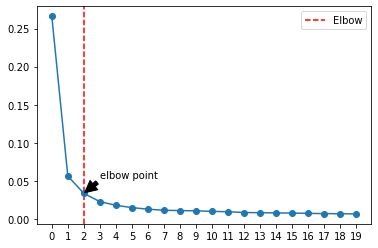

In [545]:
# # Identify an elbow and mark it on the plot.
x = range(0, len(variance_ratio))
kn = KneeLocator(x, variance_ratio, curve='convex', direction='decreasing')

x_scale = np.arange(0, len(variance_ratio) , 1)
# Plot the variance ratio and mark the elbow
plt.axvline(x=kn.knee, color='r', linestyle='--', label='Elbow')
plt.xticks(x_scale)
# label the first and last point
plt.annotate('elbow point',
             xy=(kn.knee, variance_ratio[kn.knee]),
             xytext=(kn.knee + 1,  variance_ratio[kn.knee] + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),)
# mark the elbow on the plot
plt.legend()
plt.plot(x, variance_ratio, 'o-')
plt.show()

## Step9: Calculate the cumulative variance ratios

#### First, we calculate the cumulative variance ratios by using the method np.cumsum(). Then, we use np.where() to find the smallest index of the point where the cumsum is equal or greater than 0.95. Thus we can find out that hte index of that point is 253 and the cumulative variance ratio is close to 0.95.

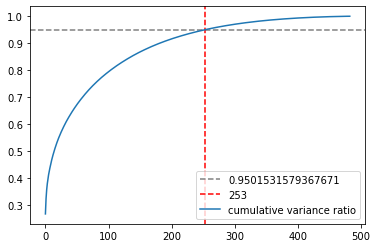

In [546]:
# Calculate the cumulative variance ratios
cum_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# find the index of the element that is first greater than 0.95
index_95 = np.where(cum_variance_ratio > 0.95)[0][0]


# Mark the x-axis for where the cumulative variance ratio is greater than or equal to 95%.
plt.axhline(y=cum_variance_ratio[index_95],
            color='grey', linestyle='--', label = cum_variance_ratio[index_95])
plt.axvline(x=index_95,
            color='r',
            linestyle='--',
            label=index_95)
# Plot all these cumulative variance ratios (x axis = principal component, y axis = cumulative variance ratio)
plt.plot(range(len(cum_variance_ratio)), cum_variance_ratio, label= 'cumulative variance ratio')
plt.legend()
plt.show()

## Step10: Normalize Returns df and Repeat PCA
#### The function normalize_returns() is used to normalize a single stock returns and whose type is pandas.Series. The function returns a pandas.Series object. Then, we can use the .apply() method to apply the function normalize_returns() to all stocks.
#### After applying PCA to the normalized returns, we can find that the first component is still the most important one and the index of elbow point is still 2. However, as the plot of the variance ratio shows, the percentage of the first variance ratio is higher than the first variance without normalization. Also, the second variance ratio is slightly higher than the second one without normalization, but the third is slightly lower than the third one without normalization.
#### Finally, in the cumcum plot, we can find the index of first variance ratio where the cumulative variance ratio is greater than or equal to 95% is 284, which is higher than the index of that point without normalization. Thus, normalization may be more helpful for the component whose index is within the range(index of elbow point) .


In [547]:
def normalize_return(re):
    _mean = np.mean(re)
    _std = np.std(re)
    return (re - _mean) / _std

# normalize the df_returns so that the columns have zero mean and unit variance
df_returns_norm = df_returns.apply(normalize_return)
# PCA on the normalized returns
pca_norm = PCA(n_components=len(df_returns_norm.columns))
pca_norm.fit(df_returns_norm)

PCA(n_components=483)

In [548]:
# Plot the first 20 explained variance ratios
variance_ratio_norm = pca_norm.explained_variance_ratio_[:20]
variance_ratio_norm

array([0.29395932, 0.05840631, 0.03094803, 0.02039706, 0.01640414,
       0.01378259, 0.01228384, 0.01068715, 0.00942511, 0.00838673,
       0.00799388, 0.00743838, 0.00695338, 0.00632926, 0.00595264,
       0.00555322, 0.00528078, 0.00514786, 0.00497307, 0.00482682])

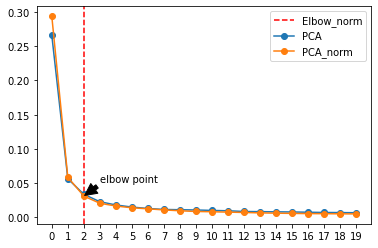

In [549]:
x_norm = range(0, len(variance_ratio_norm))
kn_norm = KneeLocator(x_norm, variance_ratio_norm, curve='convex', direction='decreasing')

# Plot the variance ratio and mark the elbow
x_scale_norm = np.arange(0, len(variance_ratio_norm) , 1)

plt.axvline(x=kn_norm.knee, color='r', linestyle='--', label='Elbow_norm')
plt.xticks(x_scale_norm)
plt.annotate('elbow point',
             xy=(kn_norm.knee, variance_ratio_norm[kn_norm.knee]),
             xytext=(kn_norm.knee + 1,  variance_ratio_norm[kn_norm.knee] + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(x_norm, variance_ratio, 'o-', label='PCA')
plt.plot(x_scale_norm, variance_ratio_norm, 'o-', label='PCA_norm')
plt.legend()
plt.show()

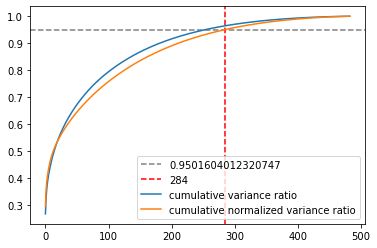

In [550]:
cum_variance_ratio_norm = np.cumsum(pca_norm.explained_variance_ratio_)
index_95_norm = np.where(cum_variance_ratio_norm > 0.95)[0][0]

plt.axhline(y=cum_variance_ratio_norm[index_95_norm],
            color='grey', linestyle='--', label = cum_variance_ratio_norm[index_95_norm])
plt.axvline(x=index_95_norm,
            color='r', linestyle='--', label=index_95_norm)
plt.plot(range(len(cum_variance_ratio_norm)), cum_variance_ratio, label='cumulative variance ratio')
plt.plot(range(len(cum_variance_ratio_norm)), cum_variance_ratio_norm, label='cumulative normalized variance ratio')
plt.legend()
plt.show()